In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
# from tensorflow.keras.layers.experimental import preprocessing 


In [2]:
# target_shape = (128,128)
target_shape = (None,None)

## Model definition

In [3]:
## upsample from pix2pix tf example
# https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py
def upsample(filters, size, activation="True"):
    """Upsamples an input.
    Conv2DTranspose => Batchnorm => Dropout => Relu
    Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
    Returns:
    Upsample Sequential Model
    """

    # initializer = tf.random_normal_initializer(0., 0.02)
    initializer = tf.keras.initializers.variance_scaling(scale=2)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    if activation:
        result.add(tf.keras.layers.ReLU())

    return result

In [4]:
def attention_block(skip, x, filters):
    initializer = tf.keras.initializers.variance_scaling(scale=2)
    
    skip = tf.keras.layers.Conv2D(filters,1,1,padding='same', kernel_initializer=initializer)(skip)
    
    theta = tf.keras.layers.Conv2D(filters, 1, strides=2, padding='same', kernel_initializer=initializer)(skip)
    phi = tf.keras.layers.Conv2D(filters, 1, strides=1, padding='same', kernel_initializer=initializer)(x) # size -> skip/2
 
    result = tf.keras.layers.Concatenate()([phi, theta])
    # result = tf.keras.layers.Add()([phi, theta])
    
    result = tf.keras.layers.ReLU()(result)
    result = tf.keras.layers.Conv2D(1,1,1,padding='same', kernel_initializer=initializer)(result)
    result = tf.keras.layers.Activation('sigmoid')(result)
    result = tf.keras.layers.Conv2DTranspose(filters, 3, strides=2, padding='same', kernel_initializer=initializer)(result) # upsample size -> skip
    result = tf.keras.layers.Multiply()([result, skip])
    
    return result 
    
def conv_block(inputs, filters, size=3, max_pooling=False, activation=True):
    
    # initializer = tf.random_normal_initializer(0., 0.02)
    # initializer = tf.keras.initializers.GlorotNormal()
    initializer = tf.keras.initializers.variance_scaling(scale=2)

    result = tf.keras.layers.Conv2D(filters, size, strides=1,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False)(inputs)

    result = tf.keras.layers.BatchNormalization()(result)

    result = tf.keras.layers.ReLU()(result)
    
    result = tf.keras.layers.Conv2D(filters, size, strides=1,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False)(result)
    result = tf.keras.layers.BatchNormalization()(result)
    
    identity = tf.keras.layers.Conv2D(filters, 1, strides=1,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False)(inputs)
    
    result = tf.keras.layers.Add()([identity, result])
    if activation:
        result = tf.keras.layers.ReLU()(result)
    
    if max_pooling:
        result = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(result)
    
    return result

In [ ]:
base_model = tf.keras.applications.EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=target_shape + (3,),
    pooling=None
)
layer_names = ['block1b_add', 'block2c_add', 'block3c_add', 'block4d_add', 'block6e_add']

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [60]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=target_shape + (3,))
    
    # filters = [64,256,512,1024,2048] # resnet
    filters = [32,64,128,256,512]
    # filters = [96,144,192,576,320] # mobilenet
    
    # Downsampling through the model
    skips = down_stack(inputs)

    x = skips[-1]
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip, f in zip(up_stack, skips, reversed(filters[:-1])):
        
        ## atention part
        gating_signal = tf.keras.layers.Conv2D(f, 1, 1, padding='same')(x) # -> shape = skip/2
        skip = attention_block(skip, gating_signal, f) # size 
        
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
        ## extra conv block
        x = conv_block(x, f, max_pooling=False)

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)
    x = conv_block(x, output_channels, max_pooling=False, activation=False)  ## extra conv block

    return tf.keras.Model(inputs=inputs, outputs=x)

## Get dataset 

In [61]:
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    
    class_weights = tf.constant([9.5, 0.5])
    
    class_weights = class_weights/tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

In [62]:
def one_hot(image, mask, weights):
    mask_one_hot = tf.one_hot(mask, 2, on_value=1.0, off_value=0.0,  axis=-1)[:,:,0,:]
    return image, mask_one_hot, weights

def one_hot_val(image, mask):
    mask_one_hot = tf.one_hot(mask, 2, on_value=1.0, off_value=0.0,  axis=-1)[:,:,0,:]
    return image, mask_one_hot


def resize_and_pad_image(image, mask, w=300, h=300, stride=32.0, keep_aspect_ratio=False):
    
    # resize image without changin aspect ratio to a size divisible by stride (for unet conv and deconv match)

    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    resize_shape = tf.cast(tf.constant([w,h]), dtype=tf.float32)
    
    if keep_aspect_ratio:
        ar_factor = tf.math.reduce_max(resize_shape / image_shape)
        resize_shape = image_shape * ar_factor

    resize_shape = tf.cast(
        tf.math.ceil(resize_shape / stride) * stride, dtype=tf.int32
    )

    image_resize =  tf.image.resize(image, resize_shape, method='bilinear')
    
    mask = tf.cast(mask, tf.float32)
    mask_resize = tf.image.resize(mask, resize_shape, method='area')
    mask_resize = tf.where(mask_resize<0.08, 1, 0)
    
    return (image_resize,mask_resize)


def preprocess_images(input_image, input_mask):
    image_string = tf.io.read_file(input_image)
    image = tf.image.decode_png(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image * 255
    
    # !! change preprocess based on feature extractor !!
    
    # image = tf.keras.applications.mobilenet.preprocess_input(image)
    # image = tf.keras.applications.resnet.preprocess_input(image)
    # image = tf.keras.applications.densenet.preprocess_input(image)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    
    

    mask_string = tf.io.read_file(input_mask)
    mask = tf.image.decode_png(mask_string, channels=1)
    mask = tf.where(mask < 224, 1, 0)
 
    image, mask = resize_and_pad_image(image, mask)
    
    
    return image, mask

def augument_images(input_image, input_mask):
    rnd = np.random.rand()
    if(rnd <0.5):
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
       
    for i in range(3):
        rnd = np.random.rand()
        if(rnd <0.4):
            input_image = tf.image.rot90(input_image)
            input_mask = tf.image.rot90(input_mask)
    
        
    return input_image, input_mask
    

In [63]:
# base_dir = './data/'
base_dir = './data2/'

# base_dir = '/archive/floorplan/data-new-iteration/'

input_dir =base_dir+ "ground_truth/"
target_dir = base_dir+"masks/"
img_size = (None, None)
num_classes = 2
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 329
./data2/ground_truth/Anhelito_1.png | ./data2/masks/Anhelito_1.png
./data2/ground_truth/Anhelito_10.png | ./data2/masks/Anhelito_10.png
./data2/ground_truth/Anhelito_11.png | ./data2/masks/Anhelito_11.png
./data2/ground_truth/Anhelito_12.png | ./data2/masks/Anhelito_12.png
./data2/ground_truth/Anhelito_13.png | ./data2/masks/Anhelito_13.png
./data2/ground_truth/Anhelito_14.png | ./data2/masks/Anhelito_14.png
./data2/ground_truth/Anhelito_15.png | ./data2/masks/Anhelito_15.png
./data2/ground_truth/Anhelito_16.png | ./data2/masks/Anhelito_16.png
./data2/ground_truth/Anhelito_17.png | ./data2/masks/Anhelito_17.png
./data2/ground_truth/Anhelito_18.png | ./data2/masks/Anhelito_18.png


In [64]:
mapIndexPosition = list(zip(input_img_paths, target_img_paths))
random.seed(10)
random.shuffle(mapIndexPosition)

shuffled_input_path = [x[0] for x in mapIndexPosition]
shuffled_target_path = [x[1] for x in mapIndexPosition]

# shuffled_input_path, shuffled_target_path = zip(*mapIndexPosition)

for input_path, target_path in zip(shuffled_input_path[:10], shuffled_target_path[:10]):
    print(input_path, "|", target_path)

./data2/ground_truth/Anhelito_75.png | ./data2/masks/Anhelito_75.png
./data2/ground_truth/DanutZzy_5.png | ./data2/masks/DanutZzy_5.png
./data2/ground_truth/Grosulik_12.png | ./data2/masks/Grosulik_12.png
./data2/ground_truth/Anhelito_9.png | ./data2/masks/Anhelito_9.png
./data2/ground_truth/Anhelito_69.png | ./data2/masks/Anhelito_69.png
./data2/ground_truth/a71.png | ./data2/masks/a71.png
./data2/ground_truth/Grosulik_62.png | ./data2/masks/Grosulik_62.png
./data2/ground_truth/DanutZzy_12.png | ./data2/masks/DanutZzy_12.png
./data2/ground_truth/Anhelito_23.png | ./data2/masks/Anhelito_23.png
./data2/ground_truth/DanutZzy_13.png | ./data2/masks/DanutZzy_13.png


In [65]:
# Let's now split our dataset in train and validation.
image_count = len(input_img_paths)

input_img_dataset = tf.data.Dataset.from_tensor_slices(shuffled_input_path[:round(image_count * 0.8)])
target_img_dataset = tf.data.Dataset.from_tensor_slices(shuffled_target_path[:round(image_count * 0.8)])

train_dataset = tf.data.Dataset.zip((input_img_dataset, target_img_dataset))
train_dataset = train_dataset.map(preprocess_images)
train_dataset = train_dataset.map(augument_images)

train_dataset = train_dataset.map(add_sample_weights)
train_dataset = train_dataset.map(one_hot) ## one hot

train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)


input_img_dataset = tf.data.Dataset.from_tensor_slices(shuffled_input_path[round(image_count * 0.8):])
target_img_dataset = tf.data.Dataset.from_tensor_slices(shuffled_target_path[round(image_count * 0.8):])

val_dataset = tf.data.Dataset.zip((input_img_dataset, target_img_dataset))
val_dataset = val_dataset.map(preprocess_images)

val_dataset = val_dataset.map(one_hot_val) ## one hot

val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.shuffle(buffer_size=1024)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)




# Utils

In [66]:
def display(display_list):
  plt.figure(figsize=(30, 30))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()

In [67]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
            
    optimizer =tf.keras.optimizers.Adam(
                learning_rate=0.0001,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=False,
                name="Adam")
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        # loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True),
        metrics=['accuracy'])

In [68]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [69]:
def create_mask(pred_mask, j):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[j]

In [70]:
def show_predictions(dataset=None, num=1, oneHot=False):
    if dataset:
        for image, mask in dataset.take(num):
            j = np.random.randint(0, len(image))
            
            pred_mask = model.predict(image)
            
            if oneHot:
                m = tf.expand_dims(tf.argmax(mask[j], axis=-1), -1)
            else:
                m = mask[j]
                
            display([image[j], m, create_mask(pred_mask,j)])
    else:
        display([sample_image[0], sample_mask[0],
                create_mask(model.predict(sample_image))])

In [71]:
for x in train_dataset.take(1):
    pass

In [72]:
# from IPython.display import clear_output
# for images, masks in train_dataset.take(2):
#     sample_image, sample_mask = images[0], masks[0]
#     display([sample_image, sample_mask])

# TRAIN

In [73]:
OUTPUT_CLASSES = 2
EPOCHS = 20

# filepath = './checkpoints/unet-densenet-res-attention.ckpt'
filepath = './checkpoints/unet-efficientdet-res-attention.ckpt'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch"
)


optimizer =tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

model = unet_model(OUTPUT_CLASSES)
model.compile(
    optimizer=optimizer,
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True),
    metrics=['accuracy'])

In [74]:
# model.fit(train_dataset.map(add_sample_weights), epochs=10, validation_data=val_dataset)#, callbacks=[model_checkpoint_callback])
model.fit(train_dataset, epochs=20, validation_data=val_dataset)#, callbacks=[model_checkpoint_callback])

Epoch 1/20
 7/33 [=====>........................] - ETA: 52s - loss: 0.0283 - accuracy: 0.3650

KeyboardInterrupt: 

In [55]:
# filepath = './checkpoints/unet-densenet-res-attention2.ckpt'
# model.load_weights(filepath)

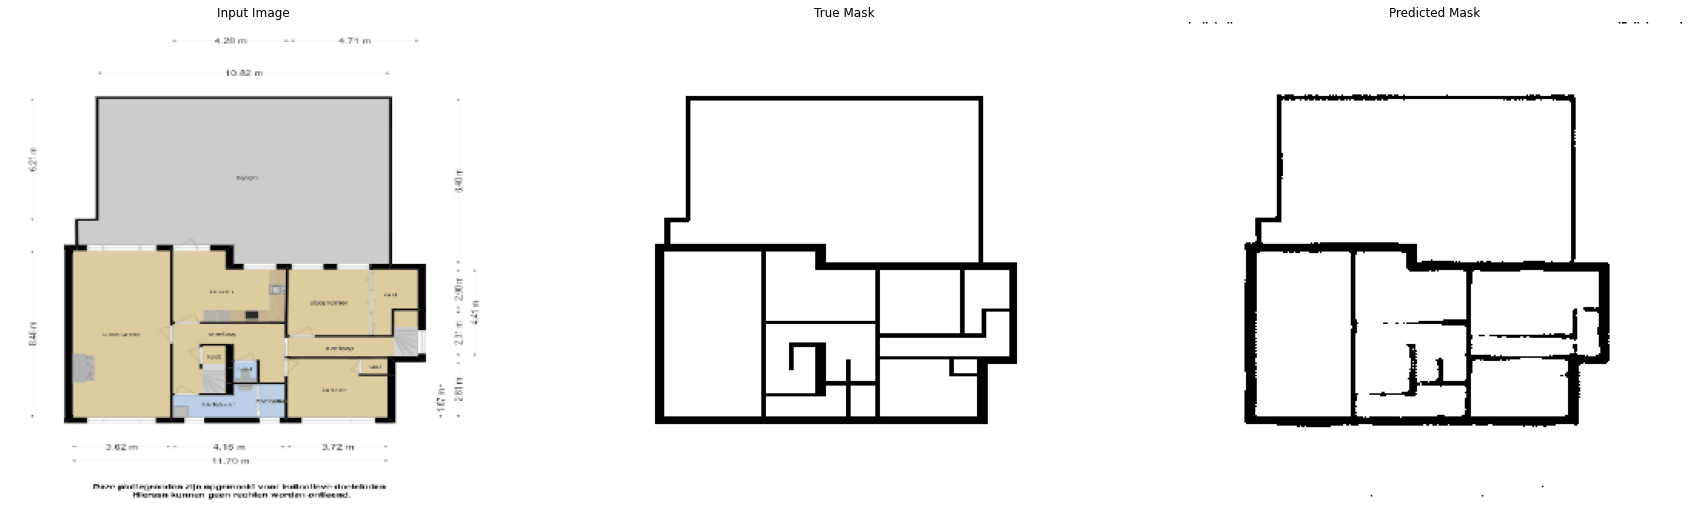

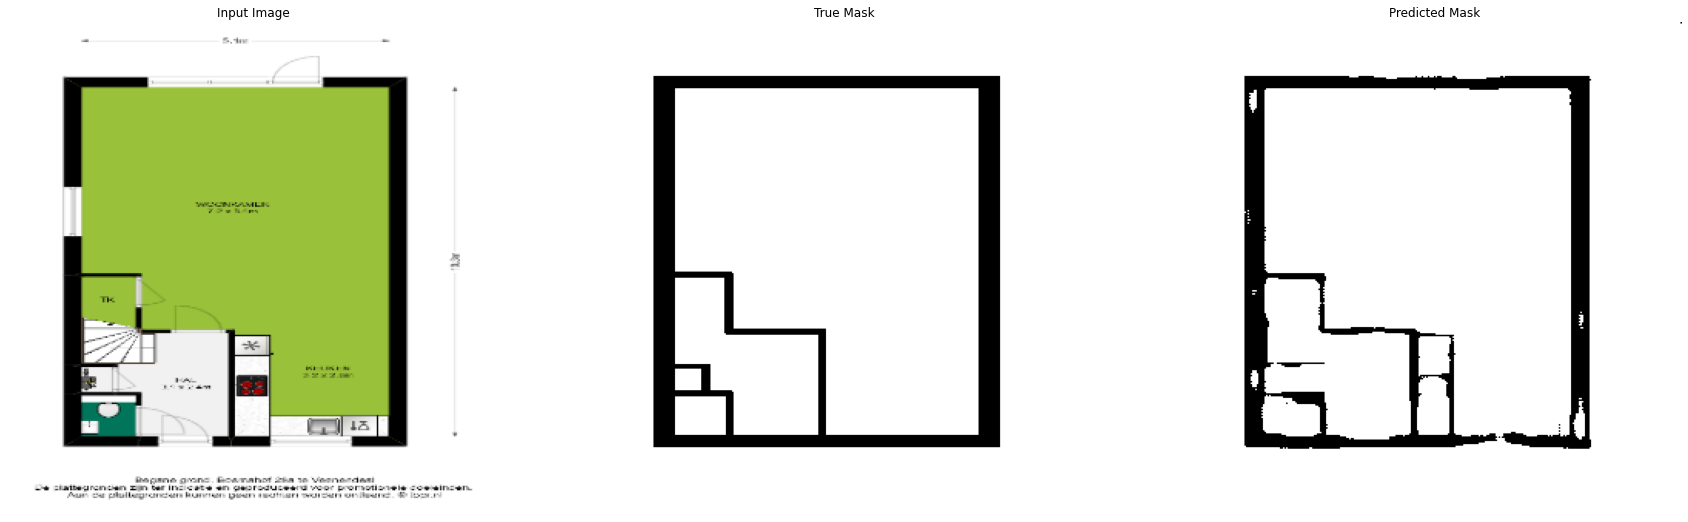

In [58]:
show_predictions(val_dataset,2, True)